In [2]:
import pycaret
pycaret.__version__

'3.3.2'

In [3]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!unzip -o Bike-Sharing-Dataset.zip

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [4]:
#prepping data
import pandas as pd
data = pd.read_csv('hour.csv')
#drop uneccesary columns
data = data.drop(columns=['instant','dteday','casual','registered'])
data

#converting season, year, month, hr,holiday, weekday, workingday, weathersit to categorical
cat_columns = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']
for cat in cat_columns:
    data[cat] = data[cat].astype('category')
#checking if correctly converted
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  category
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  cnt         17379 non-null  int64   
dtypes: category(8), float64(4), int64(1)
memory usage: 817.0 KB


In [5]:
# import pycaret regression and initialize setup
# target = 'cnt' since count of total bikes is is the target variable for regression
# session_id = 123 is a random seed

from pycaret.regression import *
s = setup(data, target = 'cnt', session_id = 123)

,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17379, 13)"
4,Transformed data shape,"(17379, 59)"
5,Transformed train set shape,"(12165, 59)"
6,Transformed test set shape,"(5214, 59)"
7,Numeric features,4
8,Categorical features,8
9,Preprocess,True


In [6]:
# Using compare_models function to evalute all performances of models using CV
# Outputs a scoring grid with average CV scores and returns best performing model based on the default metric (R2)
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28.3572,1939.4577,43.9727,0.9406,0.5173,0.6025,0.3100
et,Extra Trees Regressor,28.3325,2289.4824,47.6539,0.9298,0.3968,0.3901,0.7470
lightgbm,Light Gradient Boosting Machine,31.8388,2300.7627,47.8997,0.9296,0.5453,0.6599,0.3670
xgboost,Extreme Gradient Boosting,31.2557,2313.5550,48.0303,0.9292,0.5422,0.6446,0.0540
rf,Random Forest Regressor,33.1187,2792.8494,52.7501,0.9145,0.4857,0.5690,0.7170
dt,Decision Tree Regressor,44.3214,5734.5036,75.4889,0.8245,0.5839,0.6017,0.0410
gbr,Gradient Boosting Regressor,59.4645,6796.0909,82.3773,0.7917,0.8147,1.5180,0.2200
knn,K Neighbors Regressor,67.7478,10027.7728,100.0659,0.6930,0.9044,2.0863,0.0430
ridge,Ridge Regression,75.2100,10299.7005,101.4540,0.6843,1.0327,2.8897,0.0290
br,Bayesian Ridge,75.2068,10299.6365,101.4536,0.6843,1.0326,2.8880,0.0360


In [7]:
# Build catboost model because it avoids plot errors unlike other models
best = create_model('catboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29.4470,1922.9868,43.8519,0.9386,0.5643,0.7140
1,27.9097,1881.8128,43.3799,0.9436,0.5121,0.6251
2,27.9806,1849.1026,43.0012,0.9447,0.4971,0.5663
3,28.5167,1959.1263,44.2620,0.9409,0.4906,0.5565
4,26.3805,1522.9335,39.0248,0.9485,0.5232,0.5922
5,28.0877,1903.5251,43.6294,0.9407,0.5215,0.5857
6,29.7514,2411.1864,49.1038,0.9283,0.5015,0.5684
7,27.3622,1838.8855,42.8822,0.9478,0.5243,0.6073
8,29.5101,2133.2667,46.1873,0.9330,0.5169,0.6049


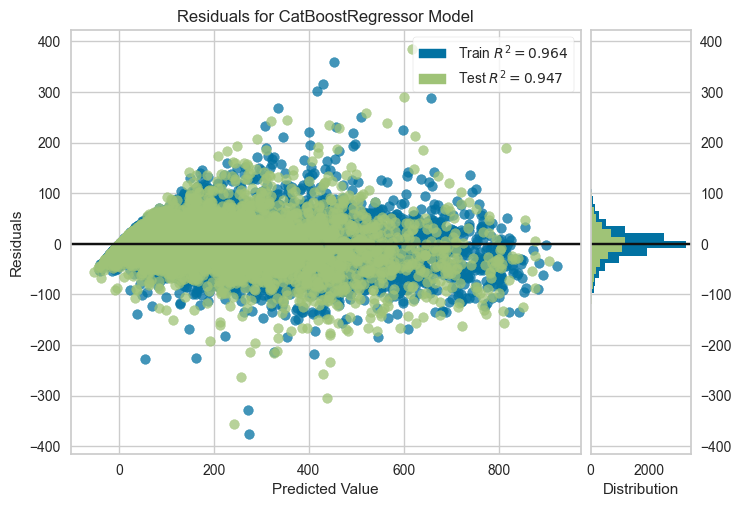

In [8]:
# plotting residuals which is the plots predicited value vs residules by trained catboost model
plot_model(best, plot = 'residuals')

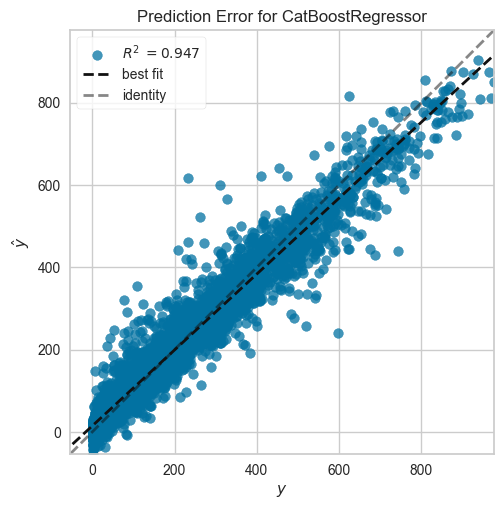

In [9]:
# plotting error which shows the predicition errors present
# Points are almost forming a diagonal line which means less errors and with R2 = 0.947 model is performing well 
plot_model(best, plot = 'error')

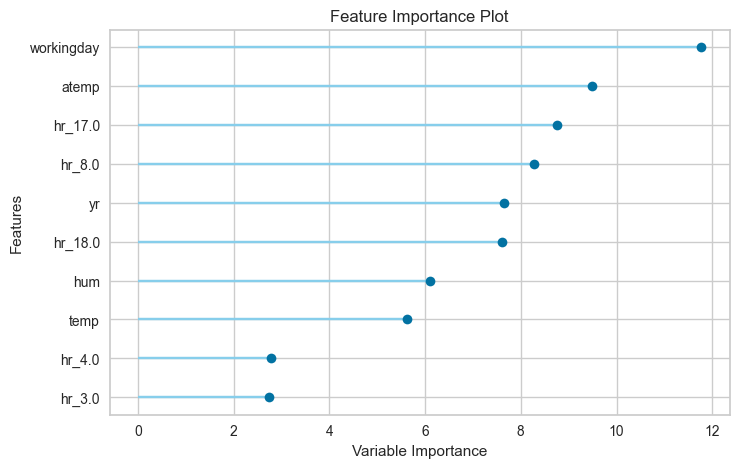

In [10]:
# plotting feature importance
# this plot shows that workingday is the most important feature and is used most by the model to make prediction
plot_model(best, plot = 'feature')

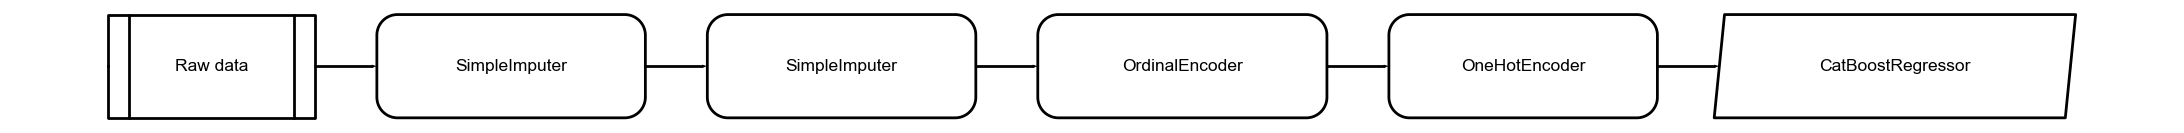

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [11]:
evaluate_model(best)

In [12]:
# PREDICTION
# Makes predictions on test set
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,27.9575,1783.9677,42.2370,0.9466,0.5092,0.5831


In [13]:
# show predictions df for first 5 rows
holdout_pred.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,prediction_label
5792,3,0,9,19,0,6,0,1,0.70,0.6667,0.74,0.1343,295,290.426510
7823,4,0,11,14,0,0,0,1,0.62,0.6212,0.43,0.4627,313,434.383148
15426,4,1,10,23,0,2,1,2,0.48,0.4697,0.77,0.0896,84,127.786476
15028,4,1,9,9,0,0,0,1,0.50,0.4848,0.51,0.3284,276,293.307739
12290,2,1,6,7,0,5,1,2,0.64,0.5758,0.89,0.1940,402,382.412987


In [14]:
# Predicting data on unseen data
# Removing target = 'cnt' and creating a copy of the original dataset
# Now returns first 5 rows
new_data = data.copy()
new_data.drop('cnt', axis=1, inplace=True)
new_data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [15]:
# Make predictions for new data using the trained model
predictions = predict_model(best, data = new_data)
# Display first 5 rows
predictions.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,prediction_label
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,26.868163
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,20.285279
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,16.547362
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,6.988507
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.917635


In [16]:
# Saving trained model pipeline to disk
save_model(best, 'my_first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['temp', 'atemp', 'hum',
                                              'windspeed'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['season', 'yr', 'mnth', 'hr',
                                              'holiday', 'weekday', 'workingday',
                                              'weathersit'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_enco...
                                                                          'data_type': dtype('float64'),
                                                                          'mapping': 0.0    0
 1.0    1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['season', 'mnt

In [17]:
# Loading saved model pipeline from before
loaded_best_pipeline = load_model('my_first_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/28/h5st7cwd1kdc3t09nt5td5fh0000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['temp', 'atemp', 'hum',
                                             'windspeed'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['season', 'yr', 'mnth', 'hr',
                                             'holiday', 'weekday', 'workingday',
                                             'weathersit'],
                                    transformer=S...
                                                                         'data_type': dtype('float64'),
                                                                         'mapping': 0.0    0
1.0    1
NaN   -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['season', 'mnth', 'hr', 'weekday',
                                             'weathersit'],
                                    transformer=OneHotEncoder(cols=['season',
                                                                    'mnth',
                                                                    'hr',
                                                                    'weekday',
                                                                    'weathersit'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x307c80d90>)])

In [18]:
# Initialize setup with normalization
s = setup(data, target = 'cnt', session_id = 123,
          normalize = True, normalize_method = 'minmax')

,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Original data shape,"(17379, 13)"
4,Transformed data shape,"(17379, 59)"
5,Transformed train set shape,"(12165, 59)"
6,Transformed test set shape,"(5214, 59)"
7,Numeric features,4
8,Categorical features,8
9,Preprocess,True


In [19]:
# Train and evalute multiple machine learning models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28.3572,1939.4577,43.9727,0.9406,0.5173,0.6025,0.2840
et,Extra Trees Regressor,28.3325,2289.4824,47.6539,0.9298,0.3968,0.3901,0.7290
lightgbm,Light Gradient Boosting Machine,31.8388,2300.7627,47.8997,0.9296,0.5453,0.6599,0.3690
xgboost,Extreme Gradient Boosting,31.2557,2313.5550,48.0303,0.9292,0.5422,0.6446,0.0540
rf,Random Forest Regressor,33.1272,2794.1345,52.7633,0.9144,0.4857,0.5692,0.7170
dt,Decision Tree Regressor,44.3184,5727.2770,75.4441,0.8247,0.5839,0.6019,0.0490
gbr,Gradient Boosting Regressor,59.4645,6796.0909,82.3773,0.7917,0.8147,1.5180,0.2250
knn,K Neighbors Regressor,67.9651,10017.0816,100.0105,0.6933,0.9067,2.0856,0.0470
ridge,Ridge Regression,75.2098,10299.7060,101.4540,0.6843,1.0327,2.8897,0.0300
br,Bayesian Ridge,75.2065,10299.6410,101.4537,0.6843,1.0326,2.8880,0.0350


In [20]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [21]:
# Compare_model will use default all models with Turbo = True
# Returns the best performing model 
compare_tree_models = compare_models(include = ['dt', 'rf', 'et', 'gbr', 'xgboost', 'lightgbm', 'catboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28.3572,1939.4577,43.9727,0.9406,0.5173,0.6025,0.3380
et,Extra Trees Regressor,28.3325,2289.4824,47.6539,0.9298,0.3968,0.3901,0.7420
lightgbm,Light Gradient Boosting Machine,31.8388,2300.7627,47.8997,0.9296,0.5453,0.6599,0.3530
xgboost,Extreme Gradient Boosting,31.2557,2313.5550,48.0303,0.9292,0.5422,0.6446,0.0530
rf,Random Forest Regressor,33.1272,2794.1345,52.7633,0.9144,0.4857,0.5692,0.7170
dt,Decision Tree Regressor,44.3184,5727.2770,75.4441,0.8247,0.5839,0.6019,0.0480
gbr,Gradient Boosting Regressor,59.4645,6796.0909,82.3773,0.7917,0.8147,1.5180,0.2270


In [22]:
#  Returned trained model object
compare_tree_models

In [23]:
# Using pull to access scoring gird and dataframe
compare_tree_models_results = pull()
compare_tree_models_results

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28.3572,1939.4577,43.9727,0.9406,0.5173,0.6025,0.338
et,Extra Trees Regressor,28.3325,2289.4824,47.6539,0.9298,0.3968,0.3901,0.742
lightgbm,Light Gradient Boosting Machine,31.8388,2300.7627,47.8997,0.9296,0.5453,0.6599,0.353
xgboost,Extreme Gradient Boosting,31.2557,2313.5550,48.0303,0.9292,0.5422,0.6446,0.053
rf,Random Forest Regressor,33.1272,2794.1345,52.7633,0.9144,0.4857,0.5692,0.717
dt,Decision Tree Regressor,44.3184,5727.2770,75.4441,0.8247,0.5839,0.6019,0.048
gbr,Gradient Boosting Regressor,59.4645,6796.0909,82.3773,0.7917,0.8147,1.5180,0.227


In [24]:
# Sort to return 3 top models based on MAE
best_mae_models_top3 = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,28.3325,2289.4824,47.6539,0.9298,0.3968,0.3901,0.8320
catboost,CatBoost Regressor,28.3572,1939.4577,43.9727,0.9406,0.5173,0.6025,0.3050
xgboost,Extreme Gradient Boosting,31.2557,2313.5550,48.0303,0.9292,0.5422,0.6446,0.0560
lightgbm,Light Gradient Boosting Machine,31.8388,2300.7627,47.8997,0.9296,0.5453,0.6599,0.3640
rf,Random Forest Regressor,33.1272,2794.1345,52.7633,0.9144,0.4857,0.5692,0.8550
dt,Decision Tree Regressor,44.3184,5727.2770,75.4441,0.8247,0.5839,0.6019,0.0510
gbr,Gradient Boosting Regressor,59.4645,6796.0909,82.3773,0.7917,0.8147,1.5180,0.2410
knn,K Neighbors Regressor,67.9651,10017.0816,100.0105,0.6933,0.9067,2.0856,0.0520
huber,Huber Regressor,72.1436,10754.2880,103.6612,0.6704,0.9720,2.4534,0.1060
par,Passive Aggressive Regressor,74.1206,11210.1257,105.8329,0.6565,0.9789,2.3666,0.0480


In [25]:
best_mae_models_top3

[ExtraTreesRegressor(n_jobs=-1, random_state=123),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)]

In [26]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [27]:
#create train linear regression wtih a default fold of 10
#Returns trained model obj as only an output
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,74.9312,9879.6702,99.3965,0.6848,1.0478,3.0036
1,73.5586,9627.1176,98.1179,0.7113,1.0021,2.6378
2,76.2162,10825.9324,104.0477,0.6760,1.0124,2.9813
3,77.5276,10727.6455,103.5743,0.6766,1.0407,3.0227
4,71.6030,9217.0609,96.0055,0.6881,1.0672,3.0747
5,75.3642,10356.6568,101.7677,0.6776,1.0200,2.7676
6,77.4635,10880.1408,104.3079,0.6763,1.0131,2.6456
7,74.5162,10426.2577,102.1090,0.7042,1.0478,2.9913
8,76.6678,10679.8622,103.3434,0.6644,1.0399,2.8210


In [28]:
lr_results = pull()
print(type(lr_results))
lr_results

<class 'pandas.core.frame.DataFrame'>


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.493120e+01,9.879670e+03,9.939650e+01,6.848000e-01,1.0478,3.003600e+00
1,7.355860e+01,9.627118e+03,9.811790e+01,7.113000e-01,1.0021,2.637800e+00
2,7.621620e+01,1.082593e+04,1.040477e+02,6.760000e-01,1.0124,2.981300e+00
3,7.752760e+01,1.072765e+04,1.035743e+02,6.766000e-01,1.0407,3.022700e+00
4,7.160300e+01,9.217061e+03,9.600550e+01,6.881000e-01,1.0672,3.074700e+00
5,7.536420e+01,1.035666e+04,1.017677e+02,6.776000e-01,1.0200,2.767600e+00
6,7.746350e+01,1.088014e+04,1.043079e+02,6.763000e-01,1.0131,2.645600e+00
7,7.451620e+01,1.042626e+04,1.021090e+02,7.042000e-01,1.0478,2.991300e+00
8,7.666780e+01,1.067986e+04,1.033434e+02,6.644000e-01,1.0399,2.821000e+00


In [29]:
# Create linear regression models with fold=3 instead
lr = create_model('lr', fold=3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,74.8695,10176.0803,100.8766,0.6892,1.0217,2.9337
1,75.8882,10336.6936,101.6695,0.6763,1.0386,2.8541
2,400240460.8128,649580044868382228480.0000,25486860239.5113,-19479499156070488.0000,1.1188,17401758.8371
Mean,133413537.1902,216526681622794076160.0000,8495620147.3525,-6493166385356829.0000,1.0597,5800588.2083
Std,188675127.0968,306214969766596575232.0000,12014621089.9343,9182723964916716.0000,0.0424,8203266.4213


In [30]:
# Train linear regression with speciic model parameters
create_model('lr', fit_intercept = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,74.8990,9899.1237,99.4943,0.6841,1.0467,2.9907
1,73.3722,9643.3325,98.2005,0.7108,0.9963,2.6034
2,76.4747,10875.0760,104.2836,0.6745,1.0142,3.0062
3,77.5474,10739.9923,103.6339,0.6763,1.0414,3.0367
4,71.5603,9222.9714,96.0363,0.6879,1.0722,3.0735
5,75.3455,10340.3341,101.6874,0.6781,1.0174,2.7685
6,77.5245,10885.4224,104.3332,0.6762,1.0159,2.6578
7,74.4468,10431.0895,102.1327,0.7041,1.0427,2.9924
8,76.8245,10686.2376,103.3743,0.6642,1.0331,2.8404


LinearRegression(fit_intercept=False, n_jobs=-1)

In [31]:
# Train linear regression and return train score alongwith C
create_model('lr', return_train_score=True)

LinearRegression(n_jobs=-1)

In [32]:
# TUNING MODEL
# Train a dt model with the default parameters
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.7362,6388.2909,79.9268,0.7962,0.6548,0.8976
1,45.0148,6037.6984,77.7026,0.8189,0.6058,0.6423
2,45.4930,6110.6532,78.1707,0.8171,0.5945,0.6510
3,44.0764,5868.0386,76.6031,0.8231,0.5607,0.5225
4,38.3829,3641.4856,60.3447,0.8768,0.5177,0.4761
5,44.6554,5422.5090,73.6377,0.8312,0.5598,0.5105
6,48.0436,6827.6554,82.6296,0.7969,0.5997,0.6842
7,41.6776,4920.5444,70.1466,0.8604,0.5752,0.5771
8,44.6579,6005.4276,77.4947,0.8113,0.5840,0.5570


In [33]:
# Tune hyperparameters of dt
tuned_dt = tune_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,73.7569,10708.3351,103.4811,0.6583,1.0279,2.5770
1,65.2483,8504.7546,92.2212,0.7449,1.0461,2.7082
2,70.6891,9651.1380,98.2402,0.7111,1.0846,2.8689
3,73.2860,10754.5451,103.7041,0.6758,0.9904,2.2943
4,67.4467,8929.0062,94.4934,0.6979,1.0571,2.8522
5,64.0508,8085.9310,89.9218,0.7483,0.9691,2.3230
6,72.9186,11067.8364,105.2038,0.6707,1.0789,2.8419
7,66.6832,8876.2951,94.2141,0.7482,1.1099,3.0481
8,67.7530,9255.8071,96.2071,0.7092,1.0413,2.5716


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
# define the tuning grid
dt_grid = {'max_depth' : [None, 2, 4, 6, 8, 10, 12]}

# tune model with custom grid and metric = MAE
tuned_dt = tune_model(dt, custom_grid = dt_grid, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.7362,6388.2909,79.9268,0.7962,0.6548,0.8976
1,45.0148,6037.6984,77.7026,0.8189,0.6058,0.6423
2,45.4930,6110.6532,78.1707,0.8171,0.5945,0.6510
3,44.0764,5868.0386,76.6031,0.8231,0.5607,0.5225
4,38.3829,3641.4856,60.3447,0.8768,0.5177,0.4761
5,44.6554,5422.5090,73.6377,0.8312,0.5598,0.5105
6,48.0436,6827.6554,82.6296,0.7969,0.5997,0.6842
7,41.6776,4920.5444,70.1466,0.8604,0.5752,0.5771
8,44.6579,6005.4276,77.4947,0.8113,0.5840,0.5570


Fitting 10 folds for each of 7 candidates, totalling 70 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [35]:
# Accessing the tuner object 
tuned_dt, tuner = tune_model(dt, return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,73.7569,10708.3351,103.4811,0.6583,1.0279,2.5770
1,65.2483,8504.7546,92.2212,0.7449,1.0461,2.7082
2,70.6891,9651.1380,98.2402,0.7111,1.0846,2.8689
3,73.2860,10754.5451,103.7041,0.6758,0.9904,2.2943
4,67.4467,8929.0062,94.4934,0.6979,1.0571,2.8522
5,64.0508,8085.9310,89.9218,0.7483,0.9691,2.3230
6,72.9186,11067.8364,105.2038,0.6707,1.0789,2.8419
7,66.6832,8876.2951,94.2141,0.7482,1.1099,3.0481
8,67.7530,9255.8071,96.2071,0.7092,1.0413,2.5716


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [36]:
# display the tuned object
tuned_dt

DecisionTreeRegressor(random_state=123)

In [37]:
# tuner object with defauly search algorithm being RandomizedSearchCV
tuner

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(memory=Memory(location=None),
                                      steps=[('numerical_imputer',
                                              TransformerWrapper(include=['temp',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed'],
                                                                 transformer=SimpleImputer())),
                                             ('categorical_imputer',
                                              TransformerWrapper(include=['season',
                                                                          'yr',
                                                                          'mnth',
                                                                          'hr',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday'...
                                                                        7, 8, 9,
                                                                        10, 11,
                                                                        12, 13,
                                                                        14, 15,
                                                                        16],
                                        'actual_estimator__max_features': [1.0,
                                                                           'sqrt',
                                                                           'log2'],
                                        'actual_estimator__min_impurity_decrease': [0,
                                                                                    0.0001,
                                                                                    0.001,
                                                                                    0.01,
                                                                                    0.0002,
                                                                                    0.002,
                                                                                    0.02,
                                                                                    0.0005,
                                                                                    0.005,
                                                                                    0.05,
                                                                                    0.1,
                                                                                    0.2,
                                                                                    0.3,
                                                                                    0.4,
                                                                                    0.5],
                                        'actual_estimator__min_samples_leaf': [2,
                                                                               3,
                                                                               4,
                                                                               5,
                                                                               6],
                                        'actual_estimator__min_samples_split': [2,
                                                                                5,
                                                                                7,
                                               

In [38]:
# tune dt using optuna
tuned_dt = tune_model(dt, search_library = 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,54.0226,7649.1917,87.4597,0.7559,0.5756,0.6729
1,54.7482,7769.9998,88.1476,0.7670,0.5998,0.7043
2,52.8509,7427.9213,86.1854,0.7777,0.5843,0.7678
3,54.0641,7580.4055,87.0655,0.7715,0.5667,0.5881
4,49.5657,6550.3827,80.9344,0.7783,0.6090,0.6876
5,51.4021,6949.3483,83.3628,0.7837,0.5693,0.6565
6,60.2225,9683.0023,98.4022,0.7119,0.6937,1.0510
7,53.8224,7270.5292,85.2674,0.7937,0.6884,0.9478
8,54.5831,7704.8951,87.7775,0.7579,0.6298,0.7135


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [39]:
# ENSEMBLE MODEL
# Esemble_model function ensembles a given estimator. Outputs a scoring grid with CV scores by fold
ensemble_model(dt, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,36.4079,3383.0797,58.1642,0.8921,0.5206,0.6866
1,34.9557,3046.8653,55.1984,0.9086,0.4957,0.6238
2,36.4809,3302.9972,57.4717,0.9011,0.5276,0.6700
3,35.3240,3310.6505,57.5383,0.9002,0.4728,0.5729
4,31.4879,2374.3104,48.7269,0.9197,0.4749,0.5328
5,34.7249,3078.5472,55.4847,0.9042,0.4763,0.4980
6,37.9469,3741.4275,61.1672,0.8887,0.5392,0.6602
7,34.1254,3034.7289,55.0884,0.9139,0.5095,0.5774
8,35.2668,3406.6562,58.3666,0.8930,0.4663,0.4945


BaggingRegressor(estimator=DecisionTreeRegressor(random_state=123),
                 random_state=123)

In [40]:
# Blend Model
# Top 3 models by MAE
best_mae_models_top3

[ExtraTreesRegressor(n_jobs=-1, random_state=123),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)]

In [41]:
# Use blend_models() to combine/blend predicitons from top 3 models
blend_models(best_mae_models_top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.7087,1820.9580,42.6727,0.9419,0.4663,0.5073
1,26.5482,1824.1167,42.7097,0.9453,0.4391,0.4518
2,26.6579,1802.7070,42.4583,0.9460,0.4527,0.4462
3,26.7595,1900.0272,43.5893,0.9427,0.4291,0.4541
4,24.3683,1389.1645,37.2715,0.9530,0.4295,0.4638
5,26.2434,1824.7408,42.7170,0.9432,0.4429,0.4590
6,28.4888,2367.3923,48.6559,0.9296,0.4397,0.4233
7,26.1235,1744.6816,41.7694,0.9505,0.4698,0.4765
8,28.2509,2311.4717,48.0778,0.9274,0.4479,0.4525


VotingRegressor(estimators=[('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=123)),
                            ('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x3594d6590>),
                            ('Extreme Gradient Boosting',
                             XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cpu',
                                          early_s...
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...))],
                n_jobs=-1)

In [42]:
# STACK MODELS
# Use stack_models function to train A meta model learns from these predicitons to make a final prediction. Will output cross validated scores.
stack_models(best_mae_models_top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,27.8665,1814.6134,42.5983,0.9421,0.4925,0.5970
1,26.0697,1761.4352,41.9695,0.9472,0.4807,0.5207
2,26.1619,1737.2048,41.6798,0.9480,0.4716,0.5010
3,26.5801,1833.8300,42.8232,0.9447,0.4607,0.5135
4,24.5470,1364.0413,36.9329,0.9538,0.4749,0.5152
5,25.9897,1764.1037,42.0012,0.9451,0.4752,0.4649
6,28.2299,2295.6382,47.9128,0.9317,0.4563,0.4984
7,25.7769,1689.8083,41.1073,0.9521,0.4999,0.5342
8,28.2675,2236.4476,47.2911,0.9297,0.4764,0.5173


StackingRegressor(cv=5,
                  estimators=[('Extra Trees Regressor',
                               ExtraTreesRegressor(n_jobs=-1,
                                                   random_state=123)),
                              ('CatBoost Regressor',
                               <catboost.core.CatBoostRegressor object at 0x359451f00>),
                              ('Extreme Gradient Boosting',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device='cpu',...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None, ...))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1)

In [43]:
# train lightgbm model
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.6192,2281.3061,47.7630,0.9272,0.5406,0.6918
1,32.1421,2264.4595,47.5863,0.9321,0.5692,0.6932
2,32.1011,2302.9066,47.9886,0.9311,0.5496,0.6930
3,32.0390,2410.4045,49.0959,0.9273,0.5200,0.6056
4,29.1343,1753.6715,41.8769,0.9407,0.5467,0.6448
5,31.1052,2242.3926,47.3539,0.9302,0.5446,0.6679
6,33.5776,2747.5670,52.4172,0.9183,0.5331,0.6031
7,30.8268,2200.2543,46.9069,0.9376,0.5575,0.7052
8,32.9186,2496.5297,49.9653,0.9216,0.5519,0.6114


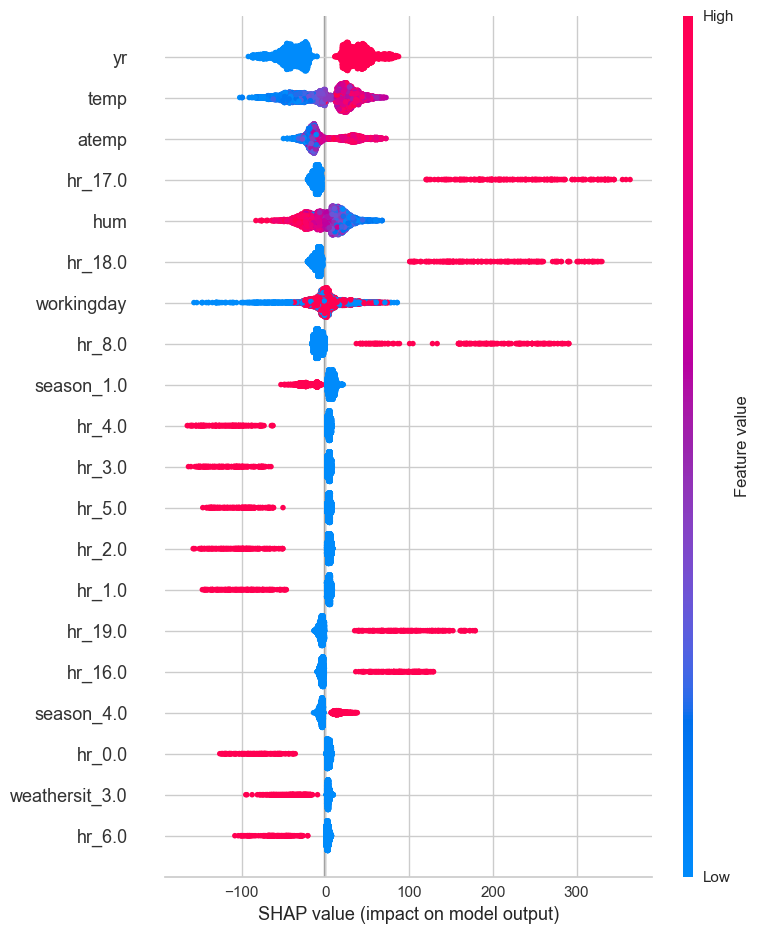

In [44]:
# interpret summary model
interpret_model(lightgbm, plot = 'summary')

In [45]:
interpret_model(lightgbm, plot = 'reason', observation = 1)

In [46]:
# Leaderboard
lb = get_leaderboard()
lb

,Model Name,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
Index,,,,,,,,
0,Linear Regression,"(TransformerWrapper(include=['temp', 'atemp', ...",2.889671e+10,1.015384e+25,1.007663e+12,-3.095266e+20,1.0650,1.256379e+09
1,Lasso Regression,"(TransformerWrapper(include=['temp', 'atemp', ...",7.665610e+01,1.097141e+04,1.047118e+02,6.638000e-01,1.0218,2.611400e+00
2,Ridge Regression,"(TransformerWrapper(include=['temp', 'atemp', ...",7.520980e+01,1.029971e+04,1.014540e+02,6.843000e-01,1.0327,2.889700e+00
3,Elastic Net,"(TransformerWrapper(include=['temp', 'atemp', ...",1.264008e+02,2.665701e+04,1.632278e+02,1.834000e-01,1.4865,6.567400e+00
4,Least Angle Regression,"(TransformerWrapper(include=['temp', 'atemp', ...",9.136758e+15,1.015121e+36,3.186096e+17,-3.094464e+31,3.8332,3.972503e+14
...,...,...,...,...,...,...,...,...
59,Decision Tree Regressor,"(TransformerWrapper(include=['temp', 'atemp', ...",4.431840e+01,5.727277e+03,7.544410e+01,8.247000e-01,0.5839,6.019000e-01
60,Decision Tree Regressor,"(TransformerWrapper(include=['temp', 'atemp', ...",3.529750e+01,3.198628e+03,5.647130e+01,9.021000e-01,0.4956,5.843000e-01
61,Voting Regressor,"(TransformerWrapper(include=['temp', 'atemp', ...",2.687440e+01,1.887811e+03,4.334280e+01,9.422000e-01,0.4441,4.595000e-01


In [47]:
# selecting the best model based on MAE
lb.sort_values(by='MAE', ascending=True)['Model'].iloc[0]

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['temp', 'atemp', 'hum',
                                             'windspeed'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['season', 'yr', 'mnth', 'hr',
                                             'holiday', 'weekday', 'workingday',
                                             'weathersit'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_enco...
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=LinearRegression(n_jobs=-1),
                                   n_jobs=-1)]])

In [48]:
# AUTOML
# Find the best model based on CV metrics
automl()

LinearRegression(n_jobs=-1)